In [21]:
from tqdm import tqdm
import os
import numpy as np
import argparse
import dlib
import cv2
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import ray

from PIL import Image

In [2]:
dlib_path = '/workspace/gan/3D-FM-GAN/pretraiend/shape_predictor_68_face_landmarks.dat'
cnn_path = '/workspace/gan/3D-FM-GAN/pretraiend/mmod_human_face_detector.dat'

detector = dlib.cnn_face_detection_model_v1(cnn_path)
predictor = dlib.shape_predictor(dlib_path)

In [3]:
dlib_list = ['03421.png',
 '04229.png',
 '09220.png',
 '09256.png',
 '11385.png',
 '15799.png',
 '16010.png',
 '30261.png',
 '30555.png',
 '64849.png',
 '27150.png',
 '25314.png',
 '17329.png',
 '62247.png',
 '56939.png',
 '66524.png',
 '22704.png',
 '10003.png',
 '42139.png',
 '05262.png',
 '09118.png',
 '22894.png',
 '44923.png',
 '58221.png',
 '04428.png',
 '27757.png',
 '28975.png',
 '69963.png',
 '01268.png',
 '64799.png',
 '51836.png',
 '00088.png',
 '08008.png',
 '65576.png',
 '30544.png',
 '19004.png',
 '68241.png',
 '17170.png',
 '59521.png',
 '46492.png',
 '51438.png',
 '48156.png',
 '65486.png',
 '44067.png',
 '61776.png',
 '34751.png',
 '63273.png',
 '39367.png',
 '32644.png',
 '22674.png',
 '31181.png',
 '13418.png',
 '22872.png',
 '47644.png',
 '53541.png',
 '55371.png',
 '29365.png',
 '27566.png',
 '29520.png',
 '33594.png',
 '27123.png',
 '04779.png',
 '02135.png',
 '08550.png',
 '43627.png',
 '64667.png',
 '39137.png',
 '22194.png',
 '66256.png',
 '07185.png',
 '23932.png',
 '18275.png',
 '66132.png',
 '07859.png',
 '42658.png',
 '39255.png',
 '53517.png',
 '40572.png',
 '38779.png',
 '07238.png',
 '13587.png',
 '02466.png',
 '29851.png',
 '67811.png',
 '66364.png',
 '68749.png']

In [4]:
dlib_img_path_list = []
for d in dlib_list:
    dlib_img_path_list.append(list(Path('/workspace/gan/3D-FM-GAN/data/ffhq/images').glob(f'*/{d}'))[0])

In [12]:
cnn_done_list = list(Path('/workspace/gan/3D-FM-GAN/data/ffhq/dlib_detections').rglob('*.txt'))

cnn_done_img_list = []
for d in cnn_done_list:
    cnn_done_img_list.append(list(Path('/workspace/gan/3D-FM-GAN/data/ffhq/images').glob(f'*/{d.stem}.png'))[0])

In [14]:
len(cnn_done_img_list)

77

In [15]:
len(dlib_img_path_list)

86

In [23]:
remain_path = list(set(dlib_img_path_list) - set(cnn_done_img_list))

In [24]:
remain_path

[PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/17000/17329.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/33000/33594.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/55000/55371.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/58000/58221.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/22000/22194.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/04000/04779.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/68000/68241.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/04000/04229.png'),
 PosixPath('/workspace/gan/3D-FM-GAN/data/ffhq/images/27000/27566.png')]

In [31]:
len(remain_path)

9

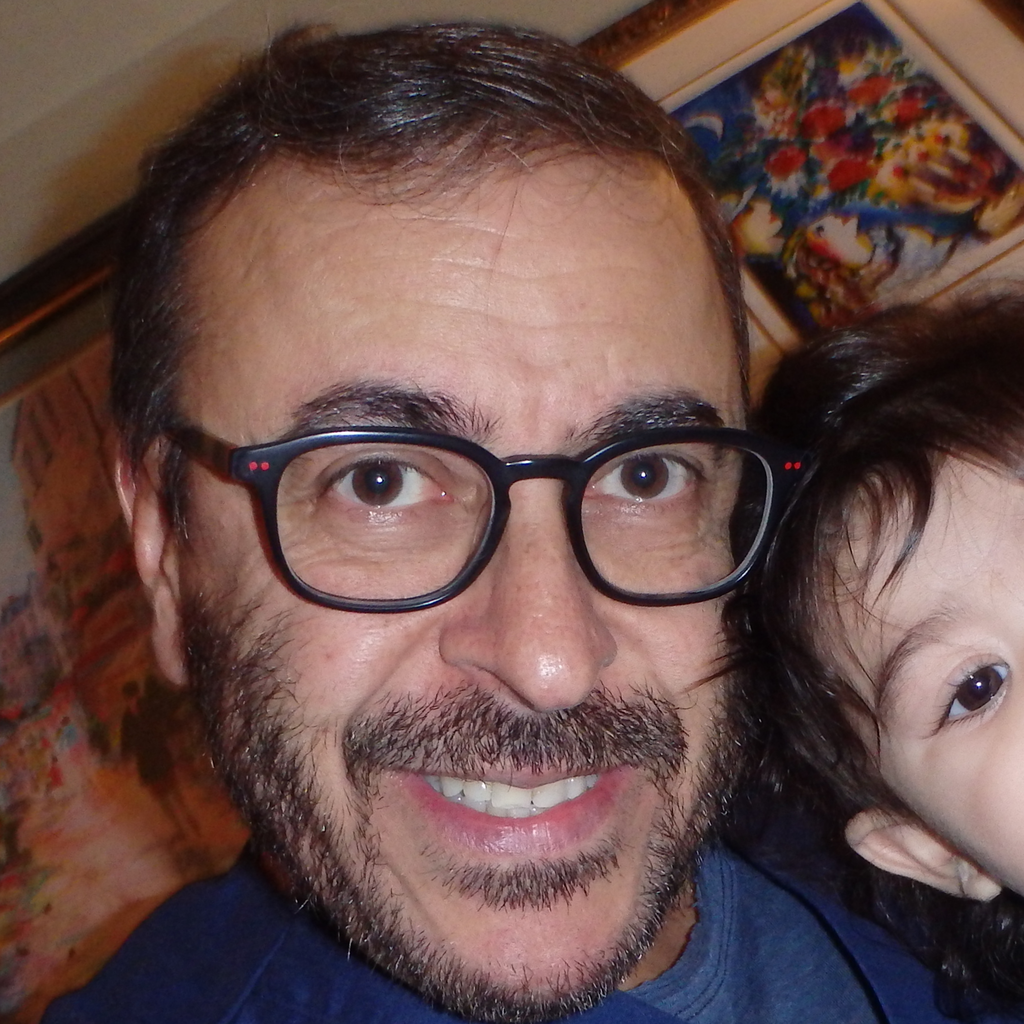

In [26]:
Image.open(remain_path[0])

In [27]:
def lmk_to_np(shape, dtype="int32"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

def extract_5p(lm, dtype="int32"):
    lm_idx = np.array([31, 37, 40, 43, 46, 49, 55]) - 1
    lm5p = np.stack([lm[lm_idx[0], :], np.mean(lm[lm_idx[[1, 2]], :], 0), np.mean(
        lm[lm_idx[[3, 4]], :], 0), lm[lm_idx[5], :], lm[lm_idx[6], :]], axis=0)
    lm5p = lm5p[[1, 2, 0, 3, 4], :].astype(dtype)
    
    return lm5p  # [left_eye, right_eye, nose, left_mouth, right_mouth]

def calc_proximity(cent_h,cent_w, lm):
    prox = 0
    for p in lm:
        prox += (np.sqrt((p[0]-cent_h)**2 + (p[1]-cent_w)**2))

    return prox

def save_lmks_to_file(lm, file):
    with open(file, 'w') as f:
        for i in range(len(lm)):
            f.write(str(lm[i][0])+" "+str(lm[i][1])) # x,y coordinates
            
            if i != len(lm)-1:
                f.write('\n')

In [ ]:
landmark_path = Path('/workspace/gan/3D-FM-GAN/data/ffhq/dlib_detections')
landmark_path.mkdir(parents=True, exist_ok=True)

for path in tqdm(remain_path, total=len(remain_path)):
        image = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        save_path = landmark_path.joinpath(path.stem+'.txt')
        
        H, W = image.shape[0], image.shape[1]
        rects = detector(image, 1)

        lmks = None
        face_cnt = 0

        prev_proximity = proximity = 99999
        final_lmk_5p = None
        
        for (i, rect) in enumerate(rects):
            shape = predictor(image, rect)
            lmks = lmk_to_np(shape)

            if np.sum(lmks < 0) > 0 or np.sum(lmks >= H) > 0 or np.sum(lmks >= W) > 0: 
                continue
            else:
                face_cnt += 1
            lmk_5p = extract_5p(lmks)
            proximity = calc_proximity(H//2,W//2, lmk_5p)
            if proximity <= prev_proximity:
                final_lmk_5p = lmk_5p
                prev_proximity = proximity
            else:
                ...
        if final_lmk_5p is not None:
            print(path)
            # vis(H, W, final_lmk_5p, image)
            save_lmks_to_file(final_lmk_5p, save_path)

In [29]:
from mtcnn import MTCNN